# ZFOURGE Bolometric Luminosity Functions

### Import and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u

F_comp = 80 # flux completeness %
min_count = 5 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(8, 14, 0.25) # luminosity bin edges
# lum_bin_edges = np.arange(8, 14, 0.5) # luminosity bin edges
print(f'Luminosity bin edges: {lum_bin_edges}')
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN5.csv')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN5.csv')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN5.csv')
df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
old_df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
print(f'Number of sources: {len(df)}')

# Use Mask
df = df[df['Use'] == 1]
print(f'Number of sources Use=1: {len(df)}')

# LIR Mask
df = df[df['LIR'] > 0]
print(f'Number of sources LIR>0: {len(df)}')

# F24 Mask
df = df[df['F24'] > 0]
print(f'Number of sources F24>0: {len(df)}')

# Redshift Mask
z_mask = (df['zpk'] >= redshift_bins[0][0]) & (df['zpk'] <= redshift_bins[-1][1])
df = df[z_mask]
print(f'Number of sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(df)}')

# AGN Mask
AGN_mask = (df['irAGN'] == 1) | (df['radAGN'] == 1) | (df['xAGN'] == 1)
df = df[~AGN_mask]
print(f'Number of sources AGN=0: {len(df)}')

Luminosity bin edges: [ 8.    8.25  8.5   8.75  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75
 11.   11.25 11.5  11.75 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75]
Number of sources: 73790
Number of sources Use=1: 37647
Number of sources LIR>0: 22997
Number of sources F24>0: 22997
Number of sources 0.0 <= z <= 6.0: 22967
Number of sources AGN=0: 22444


### Quiescent vs Starforming

In [ ]:
U_ab = 25 - 2.5*np.log10(df['FU']) # apparent magnitude -> AB magnitude
V_ab = 25 - 2.5*np.log10(df['FV']) # apparent magnitude -> AB magnitude
J_ab = 25 - 2.5*np.log10(df['FJ']) # apparent magnitude -> AB magnitude

U_V = U_ab - V_ab
V_J = V_ab - J_ab

mask_q = (U_V > 1.3) & (V_J < 1.6) & (U_V > 0.88*V_J+0.59)
print(f'Quiescent: {mask_q.sum()}')
print(f'Star-forming: {len(U_V) - mask_q.sum()}')

df = df[mask_q] # 1,502 - quiescent
# df = df[~mask_q] # 20,942 - star-forming

plt.scatter(V_J[mask_q], U_V[mask_q], s=1, label='Quiescent', color='red')
plt.scatter(V_J[~mask_q], U_V[~mask_q], s=1, label='Star-forming', color='blue')
plt.xlabel('$V - J$')
plt.ylabel('$U - V$')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.hlines(1.3, 0, 0.8, colors='red', linestyles='dashed')
plt.vlines(1.6, 2, 2.5, colors='red', linestyles='dashed')
plt.plot([0.8, 1.6], [1.3, 2.0], color='red', linestyle='dashed')
plt.legend()
plt.show()

### Luminosity Distribution & Bolometric Flux Limit

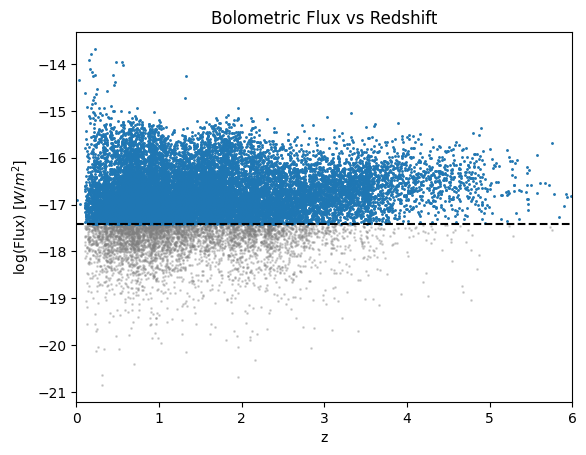

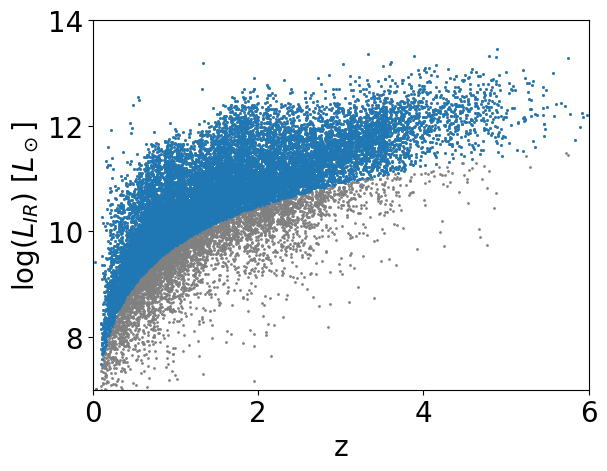

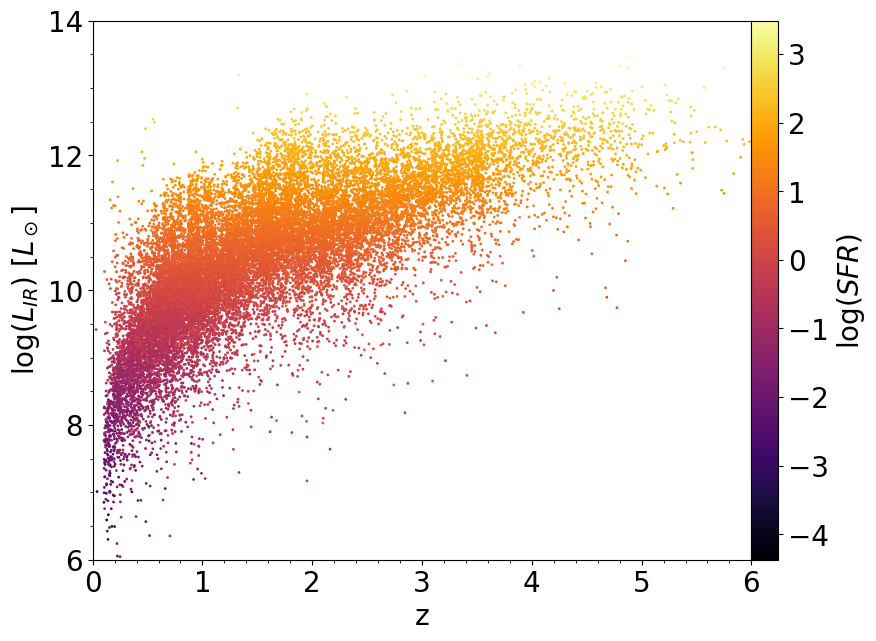

Number of galaxies: 17955
Bolometric Flux Completeness: 3.88e-18 W/m^2


In [2]:
luminosity = df['LIR'].copy().values # solar luminosities
luminosity *= 3.828 * 10 ** 26 # solar luminosity -> Watts
z = df['zpk'].values # redshift
sfr = np.log10(df['SFR']) # log(SFR)

# Plot Colours
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(redshift_bins)))
 
# Luminsity distance of galaxies
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to('m').value # m

# Bolometric Flux completeness limits
F_bol = luminosity / (4 * np.pi * d_L ** 2) # W/m^2
Fbol_lim = np.percentile(F_bol, 100-F_comp) # % of the data above perc
mask_fbol = F_bol > Fbol_lim
plt.scatter(z, np.log10(F_bol), s=1, color='grey', alpha=0.3)
plt.scatter(z[mask_fbol], np.log10(F_bol[mask_fbol]), s=1)
plt.axhline(np.log10(Fbol_lim), color='black', linestyle='--')
plt.title('Bolometric Flux vs Redshift')
plt.ylabel('log(Flux) [$W/m^2$]')
plt.xlabel('z')
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.show()

# Luminsity-redshift distribution
plt.scatter(z, np.log10(luminosity/(3.83*10**26)), s=1, color='grey')
plt.scatter(z[mask_fbol], np.log10(luminosity[mask_fbol]/(3.83*10**26)), s=1)
plt.ylabel('log($L_{IR}$) [$L_\odot$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.ylim(7, 14)
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.tick_params(axis='both', labelsize=20)
plt.show()

# Luminsity-redshift distribution
plt.figure(figsize=(10, 7))
# plt.scatter(old_df['zpk'], np.log10(old_df['LIR']), s=1, color='grey', alpha=0.3)
plt.scatter(z, np.log10(luminosity/(3.83*10**26)), s=1, cmap='inferno', c=sfr)
plt.ylabel('log($L_{IR}$) [$L_\odot$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.ylim(6, 14)
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.yticks([6,8,10,12,14])
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=20)
cbar = plt.colorbar(pad=0)
cbar.set_label('$\log(SFR)$', fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.savefig('ZFOURGE Initial Distribution.png', bbox_inches='tight')
plt.show()

print(f'Number of galaxies: {len(z[mask_fbol])}')
print(f'Bolometric Flux Completeness: {Fbol_lim:.2e} W/m^2')

### Calculate Maximum Volume

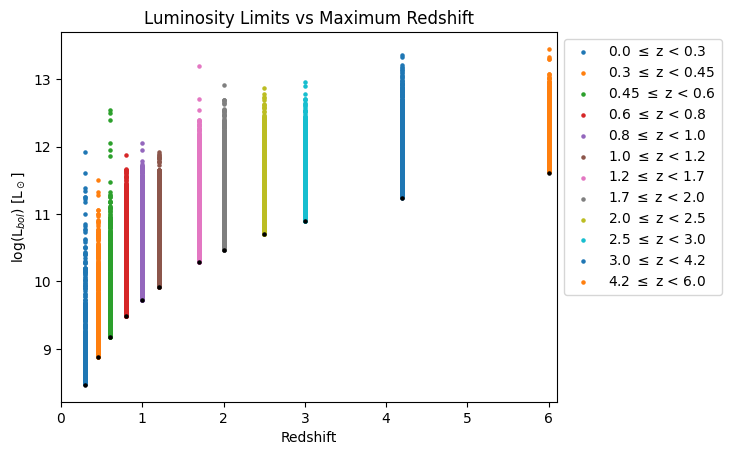

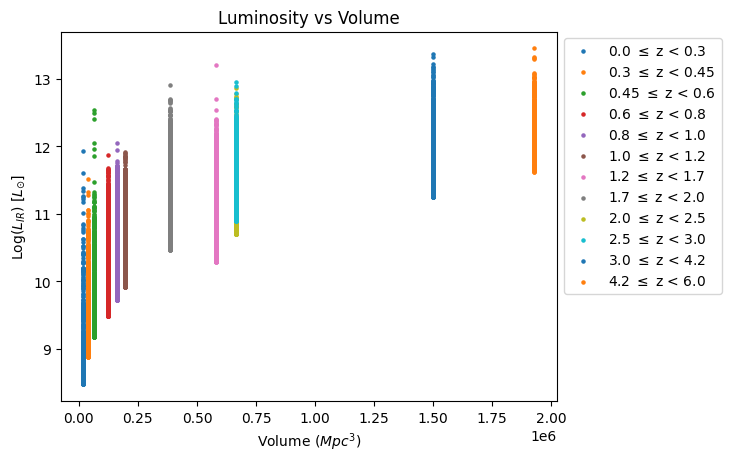

Number of sources: 16154


In [3]:
def lum_lim(z, f_lim):
    """ Luminosity distance luminosity limit as a function of redshift """
    d = cosmo.luminosity_distance(z).to(u.m).value # meters
    return 4 * np.pi * (d**2) * f_lim # W

all_data = []
zmaxs = []
L_lims = []
the_zs = []
the_sfrs = []

for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
    
    # Source lumiosity must be greater than the minimum luminosity (from luminosity distance)
    l_lim = lum_lim(z_end, Fbol_lim)
    mask_l = luminosity > l_lim
    
    # Luminosity of galaxies in each redshift bin
    lum_bin = np.log10(luminosity[mask_z & mask_fbol & mask_l]/(3.83*10**26))
    the_zs.append(z[mask_z & mask_fbol & mask_l])
    the_sfrs.append(sfr[mask_z & mask_fbol & mask_l])
    
    # Minimum and maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmax = cosmo.comoving_distance(z_end).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask_z & mask_fbol & mask_l] / (4*np.pi*Fbol_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
        
    # Limit the maximum galaxy distance to the end of the redshift bin
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each galaxy
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    # Find the maximum redshift of each source
    zmax_bin = z_at_value(cosmo.comoving_distance, dmaxs * u.Mpc)
    
    # Data
    all_data.append([vol, lum_bin])
    zmaxs.append(zmax_bin)
    L_lims.append(l_lim)
    
    # Plot
    plt.scatter(zmax_bin, lum_bin, s=5, label=f'{z_start} $\leq$ z < {z_end}')
    plt.scatter(z_end, np.log10(l_lim/(3.83*10**26)), s=5, color='black')
    
plt.title('Luminosity Limits vs Maximum Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(L$_{bol}$) [L$_\odot$]')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1]+0.1)
plt.show()

for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Luminosity vs Volume')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

print(f'Number of sources: {np.sum([len(v) for v, m in all_data])}')

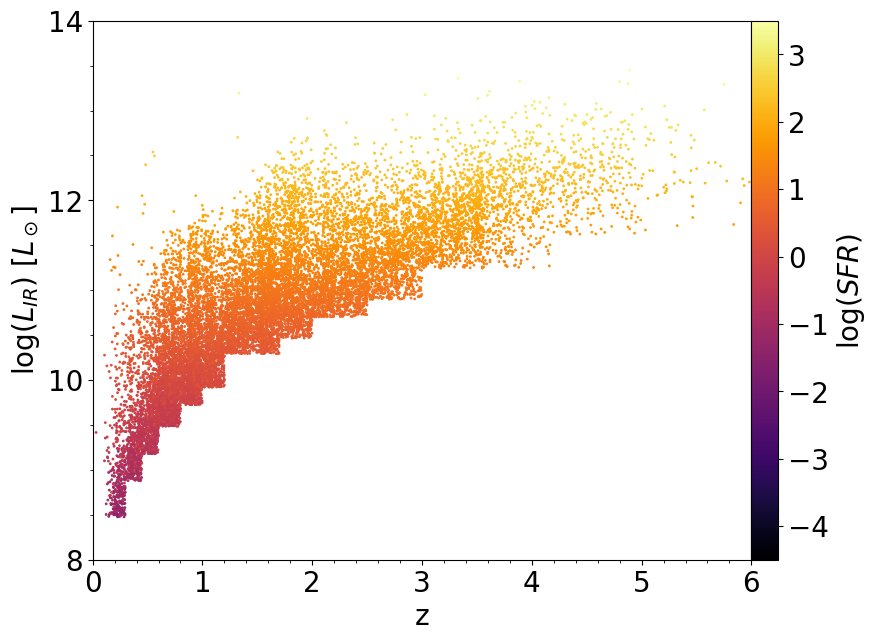

In [21]:
# Luminsity-redshift distribution
plt.figure(figsize=(10, 7))
for zs, sfrs, (_, lum_bin) in zip(the_zs, the_sfrs, all_data):
    plt.scatter(zs, lum_bin, s=1, cmap='inferno', c=sfrs, vmin=-4.5, vmax=3.5)
plt.ylabel('log($L_{IR}$) [$L_\odot$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.ylim(8, 14)
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.yticks([8,10,12,14])
plt.minorticks_on()
plt.tick_params(axis='both', labelsize=20)
cbar = plt.colorbar(pad=0)
cbar.set_label('$\log(SFR)$', fontsize=20)
cbar.ax.tick_params(labelsize=20)
plt.savefig('ZFOURGE Luminosity Distribution.png', bbox_inches='tight')
plt.show()

all_lums = [lb for _, lb in all_data]
np.savez('ZF_reduced', 
    z=np.array(the_zs, dtype=object),
    lum=np.array(all_lums, dtype=object))

In [25]:
dat = np.load('ZF_reduced.npz', allow_pickle=True)
zd = dat['z']
ld = dat['lum']
for iz, il in zip(zd, ld):
    plt.scatter(iz, il, s=1)

NpzFile 'ZF_reduced.npz' with keys: z, lum


ValueError: not enough values to unpack (expected 2, got 1)

### Counts Histograms

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey=True)
bin_edges = []
for i, (ax, (z_start, z_end), (vol, lum), min_l) in enumerate(zip(axes.flatten(), redshift_bins, all_data, L_lims)):
    mask_z = (z > z_start) & (z <= z_end)
    mask_l = luminosity > min_l
    
    # Bin the original data per redshift bin
    _, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[(z >= z_start) & (z < z_end)], 
        bins=lum_bin_edges, histtype='step', label='Original Data', facecolor='darkorange', edgecolor='black', hatch='//', fill=True, alpha=0.5)
    
    # Bin the new data with the same bins
    c, b = np.histogram(lum, bins=b)
    centers = (b[:-1] + b[1:]) / 2 # bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    b = b[1:][c_mask] # this [1:] removes the first bin edge which is impacted by the mask (would be a fraction of the bin width)
    centers = centers[c_mask]
    c = c[c_mask]
    
    # Plot the mask cutoff
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label='Completeness')
    # ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}', y=0.8, fontsize=15)
    
    # Skip if there are no bins
    if len(c) == 0:
        ax.legend()
        bin_edges.append([])
        continue
    
    # Plot the new, corrected data
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', facecolor='violet', edgecolor='black', hatch='\\', fill=True)
    # ax.tick_params(axis='y', labelsize=15, direction='in', pad=-5)
    # ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='both', labelsize=15)
    # [lab.set_horizontalalignment('left') for lab in ax.yaxis.get_ticklabels()]
    # ax.minorticks_on()
    ax.set_xlim(7.5, 13.5)
    ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
    if i == 0:
        ax.legend(loc='lower right')
    bin_edges.append(b)

fig.supylabel('Counts', fontsize=20)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', fontsize=20)
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('ZFOURGE Luminosity Binning.png', bbox_inches='tight')
plt.show()

### Luminosity Function

In [ ]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    
    try:
        delta_log_l = np.diff(bin)[0]
    except IndexError:
        lum_centers.append([])
        phi.append([])
        phi_e.append([])
        continue
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        # phi_val = len(vol_lum_bin) / vol_lum_bin[0]
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))
    
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), L_lims):
    try:
        yerr = np.array(e) / (np.array(p) * np.log(10))
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(np.log10(min_l/(3.83*10**26)), color='darkorchid', linestyle='--', label=f'Log(L) < {round(np.log10(min_l/(3.83*10**26)), 2)}')
    ax.legend()

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

for (z_start, z_end), lum_centers_z, phi_z, phi_e_z in zip(redshift_bins, lum_centers, phi, phi_e):
    if len(lum_centers_z) == 0:
        continue
    print(f'{z_start} <= z < {z_end}')
    print(lum_centers_z)
    print(np.round(np.log10(phi_z),2))
    print(np.round(np.array(phi_e_z) / (np.array(phi_z) * np.log(10)),2))
    print('\n')

### Schechter Fit

In [ ]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    
    lum = np.power(10, lum)
    
    # Attempt to fit the data
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
        perr = np.sqrt(np.diag(covars))
        schecter_params.append(params)
        schecter_errors.append(perr)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue

    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Alpha = 1.2')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *(params+perr))),
        np.log10(schechter_luminosity(long_lum, *np.abs(params-perr))),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

In [ ]:
def saunders_luminosity(L, L_star, phi_star, sigma):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
sigmas = [1.1, 1.0, 0.9, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
# sigmas = [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, sigma in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), sigmas):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Attempt to fit the data
    try:
        params, covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p, p0=p0, bounds=bounds, maxfev=10000)
        perr = np.sqrt(np.diag(covars))
        saunder_params.append(params)
        saunder_error.append(perr)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}.')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round((perr[1]) / (params[1] * np.log(10)),2)}')
    print(f'Alpha = 1.3')
    print(f'Sigma = {sigma}')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='blue', label='Saunders Fit', linestyle='--')   
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *(params+perr), sigma)), 
        np.log10(saunders_luminosity(long_lum, *np.abs(params-perr), sigma)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Schechter & Saunders

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

# Schechter Function
for ax, params, perr in zip(axes.flatten(), schecter_params, schecter_errors):
    if len(params) == 0:
        continue
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')

# Saunders Function
for ax, params, perr, sigma in zip(axes.flatten(), saunder_params, saunder_error, sigmas):
    if len(params) == 0:
        continue
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='blue', label='Saunders Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(saunders_luminosity(long_lum, *p_down, sigma)),
        np.log10(saunders_luminosity(long_lum, *p_up, sigma)),
        color='blue', alpha=0.2, label='Fit Error')

# Luminosity Function
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    try:
        yerr = np.array(e) / (np.array(p) * np.log(10))        
    except TypeError:
        continue
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Parameter Evolution

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

# Schechter Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, schecter_params, schecter_errors)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='red', label='Schechter' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='red')
    except IndexError:
        continue

# Saunders Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, saunder_params, saunder_error)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='blue', label='Saunders' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='blue')
    except IndexError:
        continue

ax[0].set_ylabel('$L_{*}$')
ax[1].set_ylabel('$\phi_{*}$')
ax[0].legend(loc='lower right')
ax[1].set_xlim(0, 5.5)
ax[0].set_ylim(10**7.5, 10**13)
ax[1].set_ylim(10**-5, 10**-1)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

In [ ]:
test_lums = np.unique(np.hstack(np.array(lum_centers, dtype=object)))[::2]
print(test_lums)
redshift_centers = np.mean(redshift_bins, axis=1)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(test_lums)))

class_phi = []
for l in test_lums:
    lum_phi = []
    for lcs, p, zc in zip(lum_centers, phi, redshift_centers):
        if l in lcs:
            lum_phi.append((zc, p[lcs.index(l)]))
    class_phi.append(lum_phi)

for cp, col, tl in zip(class_phi, colors, test_lums):
    zx = np.array(cp)[:,0]
    py = np.array(cp)[:,1]
    plt.plot(zx, py, linestyle='-', marker='o', color=col, label=tl)
    
plt.yscale('log')
plt.legend()
plt.show()

### Class Evolution

In [ ]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_classes = np.arange(8, 13.5, 0.5)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_classes)))
plt.figure(figsize=(10, 7))

class_phi = []
for lum in luminosity_classes:
    lum_phi = []
    for params, perr, sigma in zip(saunder_params, saunder_error, sigmas):
    # for params, perr in zip(schecter_params, schecter_errors):
        if len(params) == 0:
            lum_phi.append([np.nan, np.nan, np.nan])
            continue
        phis = saunders_luminosity(10**lum, *params, sigma)
        phi_up = saunders_luminosity(10**lum, *(params+perr), sigma)
        phi_down = saunders_luminosity(10**lum, *np.abs(params-perr), sigma)
        # phis = schechter_luminosity(10**lum, *params)
        # phi_up = schechter_luminosity(10**lum, *(params+perr))
        # phi_down = schechter_luminosity(10**lum, *(params-perr))
        lum_phi.append([phis, phi_up-phis, phis-phi_down])
    class_phi.append(lum_phi)

for lum, lclass, c in zip(luminosity_classes, class_phi, colors):
    class_lum = np.array(lclass)
    phis = class_lum[:,0]
    phi_up = class_lum[:,1]
    phi_down = class_lum[:,2]
    plt.errorbar(redshift_centers, phis, yerr=[phi_down, phi_up], ls='--', capsize=4, marker='*', label=f'{lum}', color=c)

plt.legend(bbox_to_anchor=(1,0.9), title='log($L_\odot$)', fontsize=12)
plt.yscale('log')
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xlabel('z', fontsize=20)
plt.xticks([0,1,2,3,4,5])
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.ylim(10**-8, 10**-1)
plt.show()

In [ ]:
# lower_bound = 10**8
# upper_bound = 10**14

full_lower_bounds = np.power(10.0, np.arange(0, 32, 2)).tolist()
full_lower_bounds[0] = 0
full_upper_bounds = full_lower_bounds[1:] + [np.inf]

print(full_lower_bounds)
print(full_upper_bounds)

fig, ax = plt.subplots(figsize=(8, 6))
from scipy import integrate
from matplotlib.ticker import LogFormatterExponent

def kennicutt_sfr(rho_ir):
    return rho_ir / (1.7*10**10)

def inverse_kennicutt_sfr(sfr):
    return sfr * 1.7*10**10

def saunder_area(params, perrors, sigmas, lb, ub):
    results_area = []
    for param, perr, sigma in zip(params, perrors, sigmas):
        param = np.append(param, sigma)
        perr = np.append(perr, 0)
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area_down, _ = integrate.quad(saunders_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

def schechter_area(params, perrors, lb, ub):
    results_area = []
    for param, perr in zip(params, perrors):
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        for l, u in zip(lb, ub):
            area, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_up, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area_down, _ = integrate.quad(schechter_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
        results_area.append([sub_area, np.abs(sub_area_up-sub_area), np.abs(sub_area-sub_area_down)])

    results_area = np.array(results_area)
    area = results_area[:,0]
    area_up = results_area[:,1]
    area_down = results_area[:,2]
    return area, area_up, area_down

""" Saunder """
total_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, total_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='*', label='Saunder', color='Blue')
print(f'up_e = {np.round(area_up / (total_area* np.log(10)),2)}')
print(f'area = {np.round(np.log10(total_area),2)}')
print(f'dn_e = {np.round(area_down / (total_area* np.log(10)),2)}', '\n')
    
""" Schechter """
area, area_up, area_down = schechter_area(schecter_params, schecter_errors, full_lower_bounds, full_upper_bounds)
ax.errorbar(redshift_centers, area, yerr=[area_down, area_up], ls='none', capsize=5, marker='s', label='Schechter', color='red')

""" Saunder FIRG Contribution """
FIRG_LB = [0,      10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]
FIRG_UB = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10, 10**11]
FIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, FIRG_LB, FIRG_UB)
ax.errorbar(redshift_centers, FIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='^', label='FIRG', color='purple', alpha=0.5)

""" Saunder LIRG Contribution """
LIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, [10**11], [10**12])
ax.errorbar(redshift_centers, LIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='o', label='LIRG', color='green', alpha=0.5)

""" Saunder ULIRG Contribution """
ULIRG_LB = [10**12, 10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28]
ULIRG_UB = [10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28, np.inf]
ULIRG_area, area_up, area_down = saunder_area(saunder_params, saunder_error, sigmas, ULIRG_LB, ULIRG_UB)
ax.errorbar(redshift_centers, ULIRG_area, yerr=[area_down, area_up], ls='none', capsize=5, marker='v', label='ULIRG', color='orange', alpha=0.5)

# Relative Contributions
total_area = np.array(total_area)
FIRG_area = np.round((np.array(FIRG_area) / total_area)*100, 2)
LIRG_area = np.round((np.array(LIRG_area) / total_area)*100, 2)
ULIRG_area = np.round((np.array(ULIRG_area) / total_area)*100, 2)
for FD, LD, UD, (z_start, z_end) in zip(FIRG_area, LIRG_area, ULIRG_area, redshift_bins):
    if FD > LD and FD > UD:
        field = 'FIRG'
    elif LD > FD and LD > UD:
        field = 'LIRG'
    else:
        field = 'ULIRG'
    print(f'{z_start} <= z < {z_end} - LD Cont - FIRGs: {FD}% - LIRGs: {LD}% - ULIRGs: {UD}% - Dominant: {field}')

# Luminosity Density
ax.set_ylabel(r'log($\rho_{IR}$) [$L_\odot$ $Mpc^{-3}$]', fontsize=20)
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel('z', fontsize=20)
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(10**7, 10**10)
ax.tick_params(axis='both', labelsize=20)
ax.yaxis.set_major_formatter(LogFormatterExponent(base=10))

# SFRD Secondary Axis
secax = ax.secondary_yaxis('right', functions=(kennicutt_sfr, inverse_kennicutt_sfr))
secax.set_ylabel('log(SFRD) [$M_\odot$ $yr^{-1}$ $Mpc^{-3}$]', fontsize=20)
secax.yaxis.set_major_formatter(LogFormatterExponent(base=10))
secax.tick_params(labelsize=20)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Export

In [ ]:
file_name = 'TEST_ZFOURGE_QUI'
np.savez(file_name,
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object),
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(L_lims, dtype=object),
    s=np.array(sigmas, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object))